# Project 2 - Coronavirus in China

This project consist to estimate the SIR model with the most updated data from WHO.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PDEparams as pde
import plotly
import os
import math
import sympy as sy
from scipy import integrate
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, median_absolute_error
from scipy.integrate import odeint
from scipy.optimize import differential_evolution, minimize
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from scipy.integrate import odeint
print(__version__) # requires version >= 1.9.0

In [12]:
path = 'figsModelsChina2'
if not os.path.isdir(path): os.makedirs(path)

In [13]:
# Saving figures
def save_fig(fig,figname):
    fig.savefig(os.path.join(path,figname+'.pdf'),format='pdf')

In [14]:
# Complete Database
data=pd.read_csv('CoV2019.csv')

In [15]:
china = data["China"][:27]
days = data["Days"][:27]
total = data["Total"][:27]
deaths_china = data["Death China"][:27]
other = data["Other"]
china_total = data["China"]
days_total = data["Days"]
deaths_china_total = data["Death China"]
deaths_outside_total = data["Death Outside"]


In [16]:
incidence_china=[data['China'][1]-data['China'][0]]
new_deaths_china=[data['Death China'][1]-data['Death China'][0]]
#incidence_china=[china[0]]
for i in range(1,data.shape[0]):
    incidence_china.append(data['China'][i]-data['China'][i-1])
    new_deaths_china.append(data['Death China'][i]-data['Death China'][i-1])
data['incidence_china']=incidence_china
data['new_deaths_china']=new_deaths_china

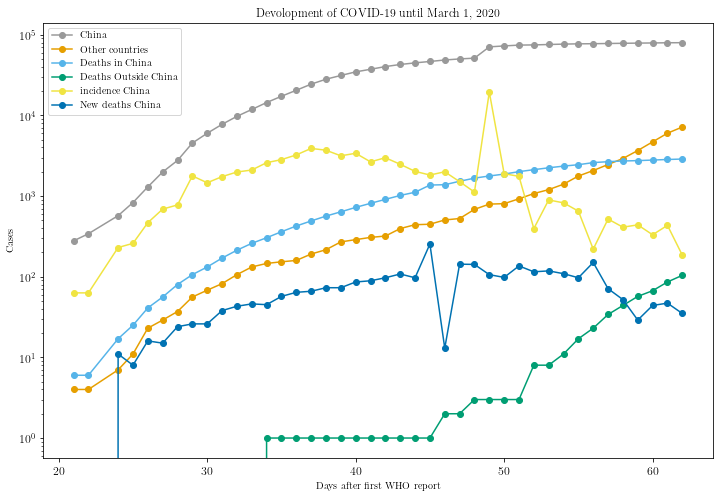

In [17]:
#Plotting data
plt.figure(figsize=(12, 8))
plt.title("Devolopment of COVID-19 until March 1, 2020")
plt.plot(days_total, china_total, '-o', label="China")
plt.plot(days_total, other, '-o', label="Other countries")
plt.plot(days_total, deaths_china_total, '-o', label="Deaths in China")
plt.plot(days_total, deaths_outside_total, '-o', label="Deaths Outside China")
plt.plot(days_total, data['incidence_china'], '-o', label="incidence China")
plt.plot(days_total, data['new_deaths_china'], '-o', label="New deaths China")
plt.yscale('log')
plt.ylabel("Cases")
plt.xlabel("Days after first WHO report")
plt.legend()

In [18]:
data=data.drop(27, axis=0)

In [19]:
tdf=range(len(data['incidence_china']))
df=pd.DataFrame({'t':tdf,'I':data['incidence_china']/(10**4)},columns=['t','I'])
df2=pd.DataFrame({'t':tdf,'I':data['incidence_china']/(10**4), 'M':data['new_deaths_china']/(10**4)},columns=['t','I','M'])

In [20]:
#For ploting
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

### Initial conditions

In [21]:
def init_s():
    return 1-init_i()

def init_sd():
    return 0

def init_e():
    return 0
    
def init_a():
    return 0

def init_id():
    return 0

def init_i():
    return df['I'][0]

def init_r():
    return 0

########################
def init_s2():
    return 1-init_i2()-init_m2()

def init_sd2():
    return 0

def init_e2():
    return 0
    
def init_a2():
    return 0

def init_id2():
    return 0

def init_i2():
    return df2['I'][0]

def init_r2():
    return 0

def init_m2():
    return df2['M'][0]


### 1. SIR, SIRm, SIMR

In [22]:
#Model
def sir(X,t,b,g):
    s,i,r=X
    
    ds=-b*(s*i)
    di=b*(s*i)-g*i
    dr=g*i
    return[ds,di,dr]

def sirm(X,t,b,g,m):
    s,i,r=X
    
    ds=-b*(s*i)
    di=b*(s*i)-g*i-m*i
    dr=g*i
    return[ds,di,dr]


def simr(X,t,b,g,m):
    s,i,m,r=X
    
    ds=-b*(s*i)
    di=b*(s*i)-g*i-m*i
    dm=m*i
    dr=g*i
    return[ds,di,dm,dr]


In [23]:
#Numeric solution of the model
def sol_sir(init,t,b,g):
    sol=odeint(sir,init,t,args=(b,g))
    return(sol)

def sol_sirm(init,t,b,g,m):
    sol=odeint(sirm,init,t,args=(b,g,m))
    return(sol)

def sol_simr(init,t,b,g,m):
    sol=odeint(simr,init,t,args=(b,g,m))
    return(sol)



In [24]:
#Parameter estimation
my_sir=pde.PDEmodel(df,sir,[init_s,init_i,init_r],bounds=[(0.3,2),(1/14,1/5)],
                   param_names=[r'$b$', r'$g$'], nvars=3, ndims=0, nreplicates=1, obsidx=[1], outfunc=None)

In [25]:
#Parameter estimation
my_sirm=pde.PDEmodel(df,sirm,[init_s,init_i,init_r],bounds=[(0.3,2),(1/14,1/5),(0.001,0.3)],
                   param_names=[r'$b$', r'$g$',r'$m$'], nvars=3, ndims=0, nreplicates=1, obsidx=[1], outfunc=None)

In [26]:
#Parameter estimation
my_simr=pde.PDEmodel(df2,simr,[init_s2,init_i2,init_m2,init_r2],bounds=[(0.3,2),(1/14,1/5),(0.001,0.3)],
                   param_names=[r'$b$', r'$g$', r'$m$'], nvars=4, ndims=0, nreplicates=1, obsidx=[1,2], outfunc=None)

In [27]:
my_sir.fit()

        $b$       $g$
0  0.553818  0.161497


In [28]:
my_sirm.fit()

        $b$       $g$       $m$
0  0.553727  0.089717  0.071758


In [29]:
my_simr.fit()

        $b$      $g$     $m$
0  0.553756  0.16147  0.1639


In [30]:
my_sirm.fit()

        $b$       $g$       $m$
0  0.553753  0.080673  0.080808


In [31]:
my_sir.best_params

,$b$,$g$
0,0.553818,0.161497


In [32]:
my_sirm.best_params


,$b$,$g$,$m$
0,0.553753,0.080673,0.080808


In [33]:
my_simr.best_params

,$b$,$g$,$m$
0,0.553756,0.16147,0.1639


In [34]:
my_sir.best_error

0.0008692712671584822

In [35]:
my_sirm.best_error

0.0008692698208022396

In [36]:
my_simr.best_error

0.0004716948759829251

In [37]:
bestPars_sir=my_sir.best_params
bBsir=bestPars_sir['$b$'][0]
gBsir=bestPars_sir['$g$'][0]

In [38]:
bestPars_sirm=my_sirm.best_params
bBsirm=bestPars_sirm['$b$'][0]
gBsirm=bestPars_sirm['$g$'][0]
mBsirm=bestPars_sirm['$m$'][0]

In [39]:
bestPars_simr=my_simr.best_params
bBsimr=bestPars_simr['$b$'][0]
gBsimr=bestPars_simr['$g$'][0]
mBsimr=bestPars_simr['$m$'][0]

In [40]:
bestSol=odeint(sir,[init_s(),init_i(),init_r()],tdf,args=(bBsir,gBsir))
#sol=odeint(sir,[shortMex.sum(axis=0),1,0],tMex,args=(bB,gB))
S=bestSol.T[0]
I=bestSol.T[1]
R=bestSol.T[2]


In [41]:
bestSolm=odeint(sirm,[init_s(),init_i(),init_r()],tdf,args=(bBsirm,gBsirm,mBsirm))
#sol=odeint(sir,[shortMex.sum(axis=0),1,0],tMex,args=(bB,gB))
Sm=bestSolm.T[0]
Im=bestSolm.T[1]
Rm=bestSolm.T[2]


In [42]:
bestSolsimr=odeint(simr,[init_s2(),init_i2(),init_m2(),init_r2()],tdf,args=(bBsimr,gBsimr,mBsimr))
Sm2=bestSolsimr.T[0]
Im2=bestSolsimr.T[1]
Mm2=bestSolsimr.T[2]
Rm2=bestSolsimr.T[3]

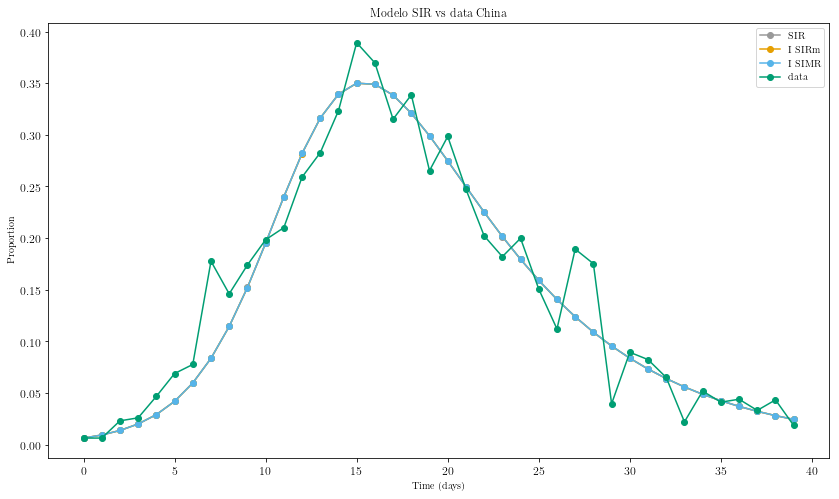

In [43]:
fig1,ax1=plt.subplots(1,1,figsize=(14,8))
ax1.plot(tdf,I,'-o',label='SIR')
ax1.plot(tdf,Im,'-o',label='I SIRm')
ax1.plot(tdf,Im2,'-o',label='I SIMR')
ax1.plot(tdf,df['I'],'-o',label='data')
ax1.set_title('Modelo SIR vs data China' ) #'+r'$\beta$='+r'%0.2f'%bBsirm+ r' $\gamma$='+r'%0.2f'%gBsirm+r' $m$='+r'%0.2f'%mBsirm
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Proportion')
ax1.legend()

### 2. SEIR, SEIRm, SEIMR (Latency)

In [44]:
def seir(X,t,b,eta,g):
    s,e,i,r=X
    
    ds=-b*(s*i)
    de=b*(s*i)-eta*e
    di=eta*e-g*i
    dr=g*i
    return[ds,de,di,dr]

def seirm(X,t,b,eta,g,m):
    s,e,i,r=X
    
    ds=-b*(s*i)
    de=b*(s*i)-eta*e
    di=eta*e-g*i-m*i
    dr=g*i
    return[ds,de,di,dr]

def seimr(X,t,b,eta,g,m):
    s,e,i,m,r=X
    
    ds=-b*(s*i)
    de=b*(s*i)-eta*e
    di=eta*e-g*i-m*i
    dm=m*i
    dr=g*i
    return[ds,de,di,dm,dr]

In [45]:
def sol_seir(init,t,b,eta,g):
    sol=odeint(seir,init,t,args=(b,eta,g))
    return(sol)

def sol_seirm(init,t,b,eta,g,m):
    sol=odeint(seirm,init,t,args=(b,eta,g,m))
    return(sol)

def sol_seimr(init,t,b,eta,g,m):
    sol=odeint(seimr,init,t,args=(b,eta,g,m))
    return(sol)

In [46]:
my_seir=pde.PDEmodel(df,seir,[init_s,init_e,init_i,init_r],bounds=[(0.3,2),(1/14,1/5),(1/14,1/5)],
                   param_names=[r'$b$', r'$eta$',r'$g$'], nvars=4, ndims=0, nreplicates=1, obsidx=[2], outfunc=None)

In [47]:
my_seirm=pde.PDEmodel(df,seirm,[init_s,init_e,init_i,init_r],bounds=[(0.3,2),(1/14,1/5),(1/14,1/5),(0.001,0.3)],
                   param_names=[r'$b$', r'$eta$',r'$g$',r'$m$'], nvars=4, ndims=0, nreplicates=1, obsidx=[2], outfunc=None)

In [48]:
my_seimr=pde.PDEmodel(df2,seimr,[init_s2,init_e2,init_i2,init_m2,init_r2],bounds=[(0.3,2),(1/14,1/5),(1/14,1/5),(0.001,0.3)],
                   param_names=[r'$b$', r'$eta$',r'$g$',r'$m$'], nvars=5, ndims=0, nreplicates=1, obsidx=[2,3], outfunc=None)

In [49]:
%%time
my_seir.fit()

   $b$  $eta$       $g$
0  2.0    0.2  0.169548
Wall time: 2.01 s


In [50]:
%%time
my_seirm.fit()

   $b$  $eta$      $g$       $m$
0  2.0    0.2  0.09744  0.072108
Wall time: 4.22 s


In [51]:
%%time
my_seimr.fit()

   $b$  $eta$      $g$       $m$
0  2.0    0.2  0.16954  0.272567
Wall time: 3.05 s


In [52]:
my_seir.best_params

,$b$,$eta$,$g$
0,2.0,0.2,0.169548


In [53]:
my_seirm.best_params

,$b$,$eta$,$g$,$m$
0,2.0,0.2,0.09744,0.072108


In [54]:
my_seimr.best_params

,$b$,$eta$,$g$,$m$
0,2.0,0.2,0.16954,0.272567


In [55]:
my_seir.best_error

0.0011505247373660168

In [56]:
my_seirm.best_error

0.0011505247373834733

In [57]:
my_seimr.best_error

0.000612322267241941

In [58]:
bestPars_seir=my_seir.best_params
bBseir=bestPars_seir['$b$'][0]
eBseir=bestPars_seir['$eta$'][0]
gBseir=bestPars_seir['$g$'][0]

In [59]:
bestPars_seirm=my_seirm.best_params
bBseirm=bestPars_seirm['$b$'][0]
eBseirm=bestPars_seirm['$eta$'][0]
gBseirm=bestPars_seirm['$g$'][0]
mBseirm=bestPars_seirm['$m$'][0]

In [60]:
bestPars_seimr=my_seimr.best_params
bBseimr=bestPars_seimr['$b$'][0]
eBseimr=bestPars_seimr['$eta$'][0]
gBseimr=bestPars_seimr['$g$'][0]
mBseimr=bestPars_seimr['$m$'][0]

In [61]:
bestSol_seir=odeint(seir,[init_s(),init_e(),init_i(),init_r()],tdf,args=(bBseir,eBseir,gBseir))
Sseir=bestSol_seir.T[0]
Eseir=bestSol_seir.T[1]
Iseir=bestSol_seir.T[2]
Rsair=bestSol_seir.T[3]

In [62]:
bestSol_seirm=odeint(seirm,[init_s(),init_e(),init_i(),init_r()],tdf,args=(bBseirm,eBseirm,gBseirm,mBseirm))
Sseirm=bestSol_seirm.T[0]
Eseirm=bestSol_seirm.T[1]
Iseirm=bestSol_seirm.T[2]
Rseirm=bestSol_seirm.T[3]

In [63]:
bestSol_seimr=odeint(seimr,[init_s2(),init_e2(),init_i2(),init_m2(),init_r2()],tdf,args=(bBseimr,eBseimr,gBseimr,mBseimr))
Sseimr=bestSol_seimr.T[0]
Eseimr=bestSol_seimr.T[1]
Iseimr=bestSol_seimr.T[2]
Mseimr=bestSol_seimr.T[3]
Rseimr=bestSol_seimr.T[4]

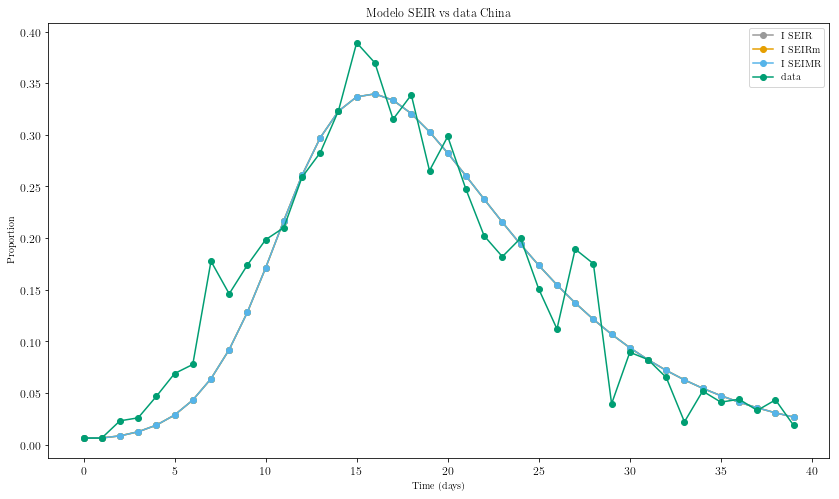

In [64]:
fig2,ax2=plt.subplots(1,1,figsize=(14,8))
ax2.plot(tdf,Iseir,'-o',label='I SEIR')
ax2.plot(tdf,Iseirm,'-o',label='I SEIRm')
ax2.plot(tdf,Iseimr,'-o',label='I SEIMR')
ax2.plot(tdf,df['I'],'-o',label='data')
ax2.set_title('Modelo SEIR vs data China') #'+r'$\beta$='+r'%0.2f'%bBseirm+ r' $\gamma$='+r'%0.2f'%gBseirm+r' $\eta$='+r'%0.2f'%eBseirm+r' $m$='+r'%0.2f'%mBseirm
ax2.set_xlabel('Time (days)')
ax2.set_ylabel('Proportion')
ax2.legend()

### 3. SAIR, SAIRM, SAIMR (Assymptomatic)

In [65]:
def sair(X,t,ba,bi,p,g):
    s,a,i,r=X
    
    ds=-(ba*a+bi*i)*s
    da=p*(ba*a*s+bi*i*s)-g*a
    di=(1-p)*(ba*a*s+bi*i*s)-g*i
    dr=g*i+g*a
    return[ds,da,di,dr]

def sairm(X,t,ba,bi,p,g,m):
    s,a,i,r=X
    
    ds=-(ba*a+bi*i)*s
    da=p*(ba*a*s+bi*i*s)-g*a
    di=(1-p)*(ba*a*s+bi*i*s)-g*i-m*i
    dr=g*i+g*a
    return[ds,da,di,dr]

def saimr(X,t,ba,bi,p,g,m):
    s,a,i,m,r=X
    
    ds=-(ba*a+bi*i)*s
    da=p*(ba*a*s+bi*i*s)-g*a
    di=(1-p)*(ba*a*s+bi*i*s)-g*i-m*i
    dm=m*i
    dr=g*i+g*a
    return[ds,da,di,dm,dr]

def saimr_gg2(X,t,ba,bi,p,g,g2,m):
    s,a,i,m,r=X
    
    ds=-(ba*a+bi*i)*s
    da=p*(ba*a*s+bi*i*s)-g*a
    di=(1-p)*(ba*a*s+bi*i*s)-g2*i-m*i
    dm=m*i
    dr=g2*i+g*a
    return[ds,da,di,dm,dr]

In [66]:
def sol_sair(init,t,ba,bi,p,g):
    sol=odeint(sair,init,t,args=(ba,bi,p,g))
    return(sol)

def sol_sairm(init,t,ba,bi,p,g,m):
    sol=odeint(sairm,init,t,args=(ba,bi,p,g,m))
    return(sol)

def sol_saimr(init,t,ba,bi,p,g,m):
    sol=odeint(saimr,init,t,args=(ba,bi,p,g,m))
    return(sol)

def sol_saimr_gg2(init,t,ba,bi,p,g,g2,m):
    sol=odeint(saimr_gg2,init,t,args=(ba,bi,p,g,g2,m))
    return(sol)

In [67]:
my_sair=pde.PDEmodel(df,sair,[init_s,init_a,init_i,init_r],bounds=[(0.3,2),(0.3,2),(0.1,0.9),(1/14,1/5)],
                   param_names=[r'$ba$', r'$bi$',r'$p$',r'$g$'], nvars=4, ndims=0, nreplicates=1, obsidx=[2], outfunc=None)

In [68]:
my_sairm=pde.PDEmodel(df,sairm,[init_s,init_a,init_i,init_r],bounds=[(0.3,2),(0.3,2),(0.1,0.9),(1/14,1/5),(0.001,0.3)],
                   param_names=[r'$ba$', r'$bi$',r'$p$',r'$g$',r'$m$'], nvars=4, ndims=0, nreplicates=1, obsidx=[2], outfunc=None)

In [69]:
my_saimr=pde.PDEmodel(df2,saimr,[init_s2,init_a2,init_i2,init_m2,init_r2],bounds=[(0.3,2),(0.3,2),(0.1,0.9),(1/14,1/5),(0.001,0.3)],
                   param_names=[r'$ba$', r'$bi$',r'$p$',r'$g$',r'$m$'], nvars=5, ndims=0, nreplicates=1, obsidx=[2,3], outfunc=None)

In [70]:
#my_saimr_gg2=pde.PDEmodel(df2,saimr_gg2,[init_s2,init_a2,init_i2,init_m2,init_r2],bounds=[(0.3,2),(0.3,2),(0.1,0.9),(1/14,1/5),(1/30,1/20),(0.001,0.3)], param_names=[r'$ba$', r'$bi$',r'$p$',r'$g$',r'$g2$',r'$m$'], nvars=5, ndims=0, nreplicates=1, obsidx=[2,3], outfunc=None)

In [71]:
%%time
my_sair.fit()

   $ba$     $bi$  $p$       $g$
0   0.3  0.57625  0.1  0.145283
Wall time: 4.14 s


In [72]:
%%time
my_sairm.fit()

   $ba$      $bi$  $p$       $g$    $m$
0   0.3  0.576208  0.1  0.144288  0.001
Wall time: 8.01 s


In [73]:
%%time
my_saimr.fit()

       $ba$      $bi$  $p$       $g$       $m$
0  0.311005  0.575202  0.1  0.145294  0.140014
Wall time: 6.54 s


In [74]:
#%%time
#my_saimr_gg2.fit()

       $ba$      $bi$       $p$       $g$  $g2$       $m$
0  0.338827  0.949418  0.596917  0.071429  0.05  0.013455
Wall time: 6.38 s


In [75]:
my_sair.best_params

,$ba$,$bi$,$p$,$g$
0,0.3,0.57625,0.1,0.145283


In [76]:
my_sairm.best_params

,$ba$,$bi$,$p$,$g$,$m$
0,0.3,0.576208,0.1,0.144288,0.001


In [77]:
my_saimr.best_params

,$ba$,$bi$,$p$,$g$,$m$
0,0.311005,0.575202,0.1,0.145294,0.140014


In [78]:
#my_saimr_gg2.best_params

,$ba$,$bi$,$p$,$g$,$g2$,$m$
0,0.338827,0.949418,0.596917,0.071429,0.05,0.013455


In [79]:
my_sair.best_error

0.0008739044440141264

In [80]:
my_sairm.best_error

0.0008739462003374392

In [81]:
my_saimr.best_error

0.0004742560829053009

In [82]:
#my_saimr_gg2.best_error

0.0014437857234954638

In [83]:
bestPars_sair=my_sair.best_params
baBsair=bestPars_sair['$ba$'][0]
biBsair=bestPars_sair['$bi$'][0]
pBsair=bestPars_sair['$p$'][0]
gBsair=bestPars_sair['$g$'][0]

In [84]:
bestPars_sairm=my_sairm.best_params
baBsairm=bestPars_sairm['$ba$'][0]
biBsairm=bestPars_sairm['$bi$'][0]
pBsairm=bestPars_sairm['$p$'][0]
gBsairm=bestPars_sairm['$g$'][0]
mBsairm=bestPars_sairm['$m$'][0]

In [85]:
bestPars_saimr=my_saimr.best_params
baBsaimr=bestPars_saimr['$ba$'][0]
biBsaimr=bestPars_saimr['$bi$'][0]
pBsaimr=bestPars_saimr['$p$'][0]
gBsaimr=bestPars_sairm['$g$'][0]
mBsaimr=bestPars_sairm['$m$'][0]

In [86]:
#bestPars_saimr_gg2=my_saimr_gg2.best_params
#baBsaimr_gg2=bestPars_saimr_gg2['$ba$'][0]
#biBsaimr_gg2=bestPars_saimr_gg2['$bi$'][0]
#pBsaimr_gg2=bestPars_saimr_gg2['$p$'][0]
#gBsaimr_gg2=bestPars_saimr_gg2['$g$'][0]
#g2Bsaimr_gg2=bestPars_saimr_gg2['$g2$'][0]
#mBsaimr_gg2=bestPars_saimr_gg2['$m$'][0]

In [87]:
bestSol_sair=odeint(sair,[init_s(),init_a(),init_i(),init_r()],tdf,args=(baBsair,biBsair,pBsair,gBsair))
Ssair=bestSol_sair.T[0]
Asair=bestSol_sair.T[1]
Isair=bestSol_sair.T[2]
Rsair=bestSol_sair.T[3]

In [88]:
bestSol_sairm=odeint(sairm,[init_s(),init_a(),init_i(),init_r()],tdf,args=(baBsairm,biBsairm,pBsairm,gBsairm,mBsairm))
Ssairm=bestSol_sairm.T[0]
Asairm=bestSol_sairm.T[1]
Isairm=bestSol_sairm.T[2]
Rsairm=bestSol_sairm.T[3]


In [89]:
bestSol_saimr=odeint(saimr,[init_s2(),init_a2(),init_i2(),init_m2(),init_r2()],tdf,args=(baBsaimr,biBsaimr,pBsaimr,gBsaimr,mBsaimr))
Ssaimr=bestSol_saimr.T[0]
Asaimr=bestSol_saimr.T[1]
Isaimr=bestSol_saimr.T[2]
Msaimr=bestSol_saimr.T[3]
Rsaimr=bestSol_saimr.T[4]

In [90]:
#bestSol_saimr_gg2=odeint(saimr_gg2,[init_s2(),init_a2(),init_i2(),init_m2(),init_r2()],tdf,args=(baBsaimr_gg2,biBsaimr_gg2,pBsaimr_gg2,gBsaimr_gg2,g2Bsaimr_gg2,mBsaimr_gg2))
#Ssaimr_gg2=bestSol_saimr_gg2.T[0]
#Asaimr_gg2=bestSol_saimr_gg2.T[1]
#Isaimr_gg2=bestSol_saimr_gg2.T[2]
#Msaimr_gg2=bestSol_saimr_gg2.T[3]
#Rsaimr_gg2=bestSol_saimr_gg2.T[4]

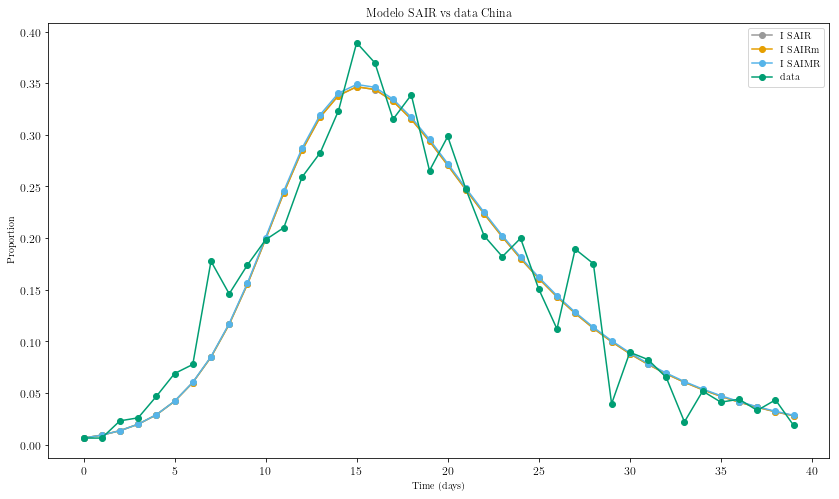

In [177]:
fig3,ax3=plt.subplots(1,1,figsize=(14,8))
ax3.plot(tdf,Isair,'-o',label='I SAIR')
ax3.plot(tdf,Isairm,'-o',label='I SAIRm')
ax3.plot(tdf,Isaimr,'-o',label='I SAIMR')
#ax3.plot(tdf,Isaimr_gg2,'-o',label='I SAIMRgg2')
ax3.plot(tdf,df['I'],'-o',label='data')
ax3.set_title('Modelo SAIR vs data China') #'+r'$\beta_i$='+r'%0.2f'%biBsairm+ r' $\beta_a$='+r'%0.2f'%baBsairm+r' $\gamma$='+r'%0.2f'%gBsairm+r' $m$='+r'%0.2f'%mBsairm
ax3.set_xlabel('Time (days)')
ax3.set_ylabel('Proportion')
ax3.legend()

### 4. SEAIR, SEAIRm, SEAIMR 

In [92]:
def seair(X,t,ba,bi,eta,p,g):
    s,e,a,i,r=X
    
    ds=-(ba*a+bi*i)*s
    de=(ba*a+bi*i)*s-eta*e
    da=p*eta*e-g*a
    di=(1-p)*eta*e-g*i
    dr=g*i+g*a
    return[ds,de,da,di,dr]


def seairm(X,t,ba,bi,eta,p,g,m):
    s,e,a,i,r=X
    
    ds=-(ba*a+bi*i)*s
    de=(ba*a+bi*i)*s-eta*e
    da=p*eta*e-g*a
    di=(1-p)*eta*e-g*i-m*i
    dr=g*i+g*a
    return[ds,de,da,di,dr]

def seaimr(X,t,ba,bi,eta,p,g,m):
    s,e,a,i,m,r=X
    
    ds=-(ba*a+bi*i)*s
    de=(ba*a+bi*i)*s-eta*e
    da=p*eta*e-g*a
    di=(1-p)*eta*e-g*i-m*i
    dm=m*i
    dr=g*i+g*a
    return[ds,de,da,di,dm,dr]

In [93]:
def sol_seair(init,t,ba,bi,eta,p,g):
    sol=odeint(seair,init,t,args=(ba,bi,eta,p,g))
    return(sol)

def sol_seairm(init,t,ba,bi,eta,p,g,m):
    sol=odeint(seairm,init,t,args=(ba,bi,eta,p,g,m))
    return(sol)

def sol_seaimr(init,t,ba,bi,eta,p,g,m):
    sol=odeint(seaimr,init,t,args=(ba,bi,eta,p,g,m))
    return(sol)

In [94]:
my_seair=pde.PDEmodel(df,seair,[init_s,init_e,init_a,init_i,init_r],bounds=[(0.3,2),(0.3,2),(1/14,1/5),(0.1,0.9),(1/14,1/5)],
                   param_names=[r'$ba$', r'$bi$',r'$eta$',r'$p$',r'$g$'], nvars=5, ndims=0, nreplicates=1, obsidx=[3], outfunc=None)

In [95]:
my_seairm=pde.PDEmodel(df,seairm,[init_s,init_e,init_a,init_i,init_r],bounds=[(0.3,2),(0.3,2),(1/14,1/5),(0.1,0.9),(1/14,1/5),(0.001,0.3)],
                   param_names=[r'$ba$', r'$bi$',r'$eta$',r'$p$',r'$g$',r'$m$'], nvars=5, ndims=0, nreplicates=1, obsidx=[3], outfunc=None)

In [96]:
my_seaimr=pde.PDEmodel(df2,seaimr,[init_s2,init_e2,init_a2,init_i2,init_m2,init_r2],bounds=[(0.3,2),(0.3,2),(1/14,1/5),(0.1,0.9),(1/14,1/5),(0.001,0.3)],
                   param_names=[r'$ba$', r'$bi$',r'$eta$',r'$p$',r'$g$',r'$m$'], nvars=6, ndims=0, nreplicates=1, obsidx=[3,4], outfunc=None)

In [97]:
%%time
my_seair.fit()

   $ba$  $bi$  $eta$  $p$       $g$
0   2.0   2.0    0.2  0.1  0.151463
Wall time: 6.78 s


In [98]:
%%time
my_seairm.fit()

   $ba$  $bi$  $eta$  $p$       $g$       $m$
0   2.0   2.0    0.2  0.1  0.071429  0.080203
Wall time: 13.9 s


In [99]:
%%time
my_seaimr.fit()

   $ba$  $bi$  $eta$  $p$       $g$       $m$
0   2.0   2.0    0.2  0.1  0.151469  0.224843
Wall time: 10.6 s


In [100]:
my_seair.best_params

,$ba$,$bi$,$eta$,$p$,$g$
0,2.0,2.0,0.2,0.1,0.151463


In [101]:
my_seairm.best_params

,$ba$,$bi$,$eta$,$p$,$g$,$m$
0,2.0,2.0,0.2,0.1,0.071429,0.080203


In [102]:
my_seaimr.best_params

,$ba$,$bi$,$eta$,$p$,$g$,$m$
0,2.0,2.0,0.2,0.1,0.151469,0.224843


In [103]:
my_seair.best_error

0.0012639988278021369

In [104]:
my_seairm.best_error

0.0012315781393337486

In [105]:
my_seaimr.best_error

0.0006690593083782591

In [106]:
bestPars_seair=my_seair.best_params
baBseair=bestPars_seair['$ba$'][0]
biBseair=bestPars_seair['$bi$'][0]
eBseair=bestPars_seair['$eta$'][0]
pBseair=bestPars_seair['$p$'][0]
gBseair=bestPars_seair['$g$'][0]

In [107]:
bestPars_seairm=my_seairm.best_params
baBseairm=bestPars_seairm['$ba$'][0]
biBseairm=bestPars_seairm['$bi$'][0]
eBseairm=bestPars_seairm['$eta$'][0]
pBseairm=bestPars_seairm['$p$'][0]
gBseairm=bestPars_seairm['$g$'][0]
mBseairm=bestPars_seairm['$m$'][0]

In [108]:
bestPars_seaimr=my_seaimr.best_params
baBseaimr=bestPars_seaimr['$ba$'][0]
biBseaimr=bestPars_seaimr['$bi$'][0]
eBseaimr=bestPars_seaimr['$eta$'][0]
pBseaimr=bestPars_seaimr['$p$'][0]
gBseaimr=bestPars_seaimr['$g$'][0]
mBseaimr=bestPars_seaimr['$m$'][0]

In [109]:
bestSol_seair=odeint(seair,[init_s(),init_e(),init_a(),init_i(),init_r()],tdf,args=(baBseair,biBseair,eBseair,pBseair,gBseair))
Sseair=bestSol_seair.T[0]
Eseair=bestSol_seair.T[1]
Aseair=bestSol_seair.T[2]
Iseair=bestSol_seair.T[3]
Rseair=bestSol_seair.T[4]


In [110]:
bestSol_seairm=odeint(seairm,[init_s(),init_e(),init_a(),init_i(),init_r()],tdf,args=(baBseairm,biBseairm,eBseairm,pBseairm,gBseairm,mBseairm))
#sol=odeint(sir,[shortMex.sum(axis=0),1,0],tMex,args=(bB,gB))
Sseairm=bestSol_seairm.T[0]
Eseairm=bestSol_seairm.T[1]
Aseairm=bestSol_seairm.T[2]
Iseairm=bestSol_seairm.T[3]
Rseairm=bestSol_seairm.T[4]

In [111]:
bestSol_seaimr=odeint(seaimr,[init_s2(),init_e2(),init_a2(),init_i2(),init_m2(),init_r2()],tdf,args=(baBseaimr,biBseaimr,eBseaimr,pBseaimr,gBseaimr,mBseaimr))
#sol=odeint(sir,[shortMex.sum(axis=0),1,0],tMex,args=(bB,gB))
Sseaimr=bestSol_seaimr.T[0]
Eseaimr=bestSol_seaimr.T[1]
Aseaimr=bestSol_seaimr.T[2]
Iseaimr=bestSol_seaimr.T[3]
Mseaimr=bestSol_seaimr.T[4]
Rseaimr=bestSol_seaimr.T[5]

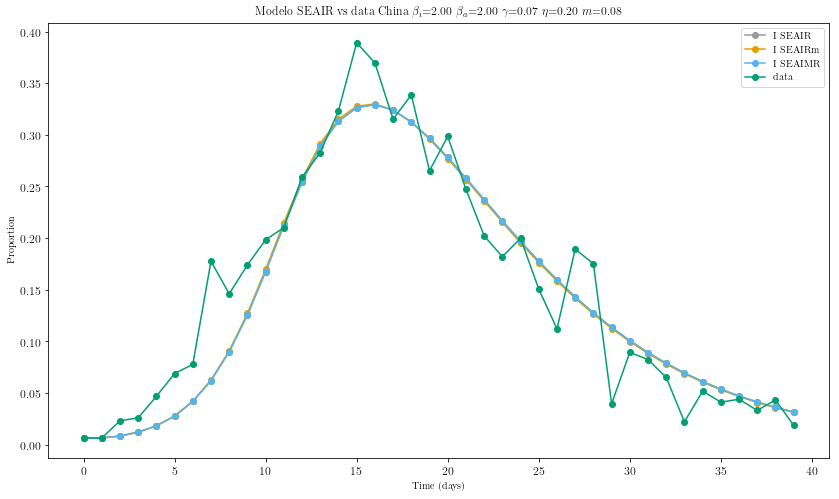

In [112]:
fig4,ax4=plt.subplots(1,1,figsize=(14,8))
ax4.plot(tdf,Iseair,'-o',label='I SEAIR')
ax4.plot(tdf,Iseairm,'-o',label='I SEAIRm')
ax4.plot(tdf,Iseaimr,'-o',label='I SEAIMR')
ax4.plot(tdf,df['I'],'-o',label='data')
ax4.set_title('Modelo SEAIR vs data China '+r'$\beta_i$='+r'%0.2f'%biBseairm+ r' $\beta_a$='+r'%0.2f'%baBseairm+r' $\gamma$='+r'%0.2f'%gBseairm+r' $\eta$='+r'%0.2f'%eBseairm+r' $m$='+r'%0.2f'%mBseairm)
ax4.set_xlabel('Time (days)')
ax4.set_ylabel('Proportion')
ax4.legend()

### 5. SDIR, SDIRm, SDIMR 

In [113]:
def sdir(X,t,bi,p,g):
    S,SD,I,R=X
    
    dS=-(bi*I)*S
    dSD=-p*(bi*I)*SD
    dI=(bi*I)*S+p*(bi*I)*SD-g*I
    dR=g*I
    return[dS,dSD,dI,dR]

def sdirm(X,t,bi,p,g,m):
    S,SD,I,R=X
    
    dS=-(bi*I)*S
    dSD=-p*(bi*I)*SD
    dI=(bi*I)*S+p*(bi*I)*SD-(g+m)*I
    dR=g*I
    return[dS,dSD,dI,dR]

def sdimr(X,t,bi,p,g,m):
    S,SD,I,M,R=X
    
    dS=-(bi*I)*S
    dSD=-p*(bi*I)*SD
    dI=(bi*I)*S+p*(bi*I)*SD-(g+m)*I
    dM=m*I
    dR=g*I
    return[dS,dSD,dI,dM,dR]

In [114]:
def sol_sdir(init,t,bi,p,g):
    sol=odeint(sdir,init,t,args=(bi,p,g))
    return(sol)

def sol_sdirm(init,t,bi,p,g,m):
    sol=odeint(sdirm,init,t,args=(bi,p,g,m))
    return(sol)

def sol_sdimr(init,t,bi,p,g,m):
    sol=odeint(sdimr,init,t,args=(bi,p,g,m))
    return(sol)

In [115]:
my_sdir=pde.PDEmodel(df,sdir,[init_s,init_sd,init_i,init_r],bounds=[(0.3,2),(1,2),(1/14,1/5)],
                   param_names=[r'$bi$',r'$p$',r'$g$'], nvars=4, ndims=0, nreplicates=1, obsidx=[2], outfunc=None)

In [116]:
my_sdirm=pde.PDEmodel(df,sdirm,[init_s,init_sd,init_i,init_r],bounds=[(0.3,2),(1,2),(1/14,1/5),(0.001,0.3)],
                   param_names=[r'$bi$',r'$p$',r'$g$',r'$m$'], nvars=4, ndims=0, nreplicates=1, obsidx=[2], outfunc=None)

In [117]:
my_sdimr=pde.PDEmodel(df2,sdimr,[init_s2,init_sd2,init_i2,init_m2,init_r2],bounds=[(0.3,2),(1,2),(1/14,1/5),(0.001,0.3)],
                   param_names=[r'$bi$',r'$p$',r'$g$',r'$m$'], nvars=5, ndims=0, nreplicates=1, obsidx=[2,3], outfunc=None)

In [118]:
%%time
my_sdir.fit()

       $bi$       $p$       $g$
0  0.553811  1.109064  0.161492
Wall time: 859 ms


In [119]:
%%time
my_sdirm.fit()

       $bi$       $p$       $g$       $m$
0  0.553624  1.767509  0.087662  0.073788
Wall time: 1.64 s


In [120]:
%%time
my_sdimr.fit()

       $bi$       $p$       $g$       $m$
0  0.553778  1.502697  0.159548  0.001937
Wall time: 2.43 s


In [121]:
my_sdir.best_params

,$bi$,$p$,$g$
0,0.553811,1.109064,0.161492


In [122]:
my_sdirm.best_params

,$bi$,$p$,$g$,$m$
0,0.553624,1.767509,0.087662,0.073788


In [123]:
my_sdimr.best_params

,$bi$,$p$,$g$,$m$
0,0.553778,1.502697,0.159548,0.001937


In [124]:
my_sdir.best_error

0.0008692709296741401

In [125]:
my_sdirm.best_error

0.0008692751676544965

In [126]:
my_sdimr.best_error

0.0004446749485663015

In [127]:
bestPars_sdir=my_sdir.best_params
biBsdir=bestPars_sdir['$bi$'][0]
pBsdir=bestPars_sdir['$p$'][0]
gBsdir=bestPars_sdir['$g$'][0]

In [128]:
bestPars_sdirm=my_sdirm.best_params
biBsdirm=bestPars_sdirm['$bi$'][0]
pBsdirm=bestPars_sdirm['$p$'][0]
gBsdirm=bestPars_sdirm['$g$'][0]
mBsdirm=bestPars_sdirm['$m$'][0]

In [129]:
bestPars_sdimr=my_sdimr.best_params
biBsdimr=bestPars_sdimr['$bi$'][0]
pBsdimr=bestPars_sdimr['$p$'][0]
gBsdimr=bestPars_sdimr['$g$'][0]
mBsdimr=bestPars_sdimr['$m$'][0]

In [130]:
bestSol_sdir=odeint(sdir,[init_s(),init_sd(),init_i(),init_r()],tdf,args=(biBsdir,pBsdir,gBsdir))
Ssdir=bestSol_sdir.T[0]
SDsdir=bestSol_sdir.T[1]
Isdir=bestSol_sdir.T[2]
Rsdir=bestSol_sdir.T[3]

In [131]:
bestSol_sdirm=odeint(sdirm,[init_s(),init_sd(),init_i(),init_r()],tdf,args=(biBsdirm,pBsdirm,gBsdirm,mBsdirm))
Ssdirm=bestSol_sdirm.T[0]
SDsdirm=bestSol_sdirm.T[1]
Isdirm=bestSol_sdirm.T[2]
Rsdirm=bestSol_sdirm.T[3]

In [132]:
bestSol_sdimr=odeint(sdimr,[init_s2(),init_sd2(),init_i2(),init_m2(),init_r2()],tdf,args=(biBsdimr,pBsdimr,gBsdimr,mBsdimr))
Ssdimr=bestSol_sdimr.T[0]
SDsdimr=bestSol_sdimr.T[1]
Isdimr=bestSol_sdimr.T[2]
Msdimr=bestSol_sdimr.T[3]
Rsdimr=bestSol_sdimr.T[4]

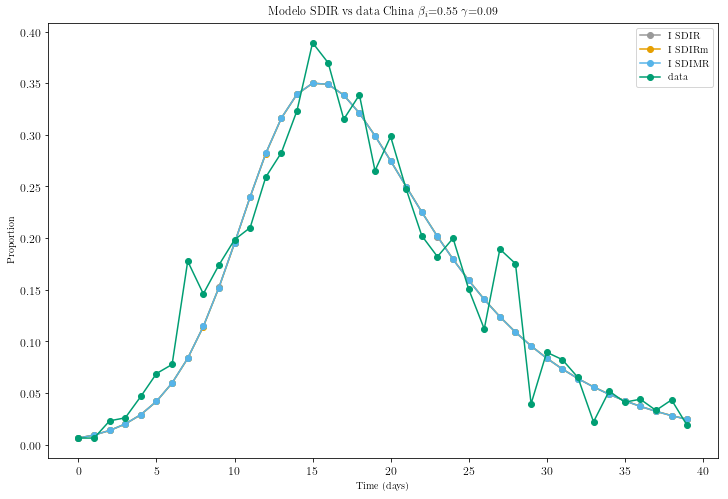

In [133]:
fig5,ax5=plt.subplots(1,1,figsize=(12,8))
ax5.plot(tdf,Isdir,'-o',label='I SDIR')
ax5.plot(tdf,Isdirm,'-o',label='I SDIRm')
ax5.plot(tdf,Isdimr,'-o',label='I SDIMR')
ax5.plot(tdf,df['I'],'-o',label='data')
ax5.set_title('Modelo SDIR vs data China '+r'$\beta_i$='+r'%0.2f'%biBsdirm+r' $\gamma$='+r'%0.2f'%gBsdirm)
ax5.set_xlabel('Time (days)')
ax5.set_ylabel('Proportion')
ax5.legend()

### 6. SIGR, SIGRm, SIGMR

In [134]:
def sigr(X,t,bi,bg,p,g):
    S,I,IG,R=X
    
    dS=-(bi*I+bg*IG)*S
    dI=(1-p)*(bi*I+bg*IG)*S-g*I
    dIG=p*(bi*I+bg*IG)*S-g*IG
    dR=g*I+g*IG
    return[dS,dI,dIG,dR]

def sigrm(X,t,bi,bg,p,g,m):
    S,I,IG,R=X
    
    dS=-(bi*I+bg*IG)*S
    dI=(1-p)*(bi*I+bg*IG)*S-g*I
    dIG=p*(bi*I+bg*IG)*S-g*IG-m*IG
    dR=g*I+g*IG
    return[dS,dI,dIG,dR]

def sigmr(X,t,bi,bg,p,g,m):
    S,I,IG,M, R=X
    
    dS=-(bi*I+bg*IG)*S
    dI=(1-p)*(bi*I+bg*IG)*S-g*I
    dIG=p*(bi*I+bg*IG)*S-g*IG-m*IG
    dM=m*IG
    dR=g*I+g*IG
    return[dS,dI,dIG,dM,dR]

In [135]:
def sol_sigr(init,t,bi,bg,p,g):
    sol=odeint(sigr,init,t,args=(bi,bg,p,g))
    return(sol)

def sol_sigrm(init,t,bi,bg,p,g,m):
    sol=odeint(sigrm,init,t,args=(bi,bg,p,g,m))
    return(sol)

def sol_sigmr(init,t,bi,bg,p,g,m):
    sol=odeint(sigmr,init,t,args=(bi,bg,p,g,m))
    return(sol)

In [136]:
my_sigr=pde.PDEmodel(df,sigr,[init_s,init_i,init_id,init_r],bounds=[(0.3,2),(0.3,2),(0.1,0.9),(1/14,1/5)],
                   param_names=[r'$bi$', r'$bg$',r'$p$',r'$g$'], nvars=4, ndims=0, nreplicates=1, obsidx=[1], outfunc=None)

In [137]:
my_sigrm=pde.PDEmodel(df,sigrm,[init_s,init_i,init_id,init_r],bounds=[(0.3,2),(0.3,2),(0.1,0.9),(1/14,1/5),(0.001,0.3)],
                   param_names=[r'$bi$', r'$bg$',r'$p$',r'$g$',r'$m$'], nvars=4, ndims=0, nreplicates=1, obsidx=[1], outfunc=None)

In [138]:
my_sigmr=pde.PDEmodel(df2,sigmr,[init_s2,init_i2,init_id2, init_m2, init_r2],bounds=[(0.3,2),(0.3,2),(0.1,0.9),(1/14,1/5),(0.001,0.3)],
                   param_names=[r'$bi$', r'$bg$',r'$p$',r'$g$',r'$m$'], nvars=5, ndims=0, nreplicates=1, obsidx=[1,3], outfunc=None)

In [139]:
%%time
my_sigr.fit()

      $bi$  $bg$  $p$       $g$
0  0.57625   0.3  0.1  0.145281
Wall time: 15 s


In [140]:
%%time
my_sigrm.fit()

       $bi$  $bg$  $p$       $g$  $m$
0  0.585444   0.3  0.1  0.144547  0.3
Wall time: 6.1 s


In [141]:
%%time
my_sigmr.fit()

       $bi$      $bg$  $p$       $g$      $m$
0  0.576495  0.306275  0.1  0.145171  0.01972
Wall time: 6.98 s


In [142]:
my_sigr.best_params

,$bi$,$bg$,$p$,$g$
0,0.57625,0.3,0.1,0.145281


In [143]:
my_sigrm.best_params

,$bi$,$bg$,$p$,$g$,$m$
0,0.585444,0.3,0.1,0.144547,0.3


In [144]:
my_sigmr.best_params

,$bi$,$bg$,$p$,$g$,$m$
0,0.576495,0.306275,0.1,0.145171,0.01972


In [145]:
my_sigr.best_error

0.0008739044406831396

In [146]:
my_sigrm.best_error

0.0008671744345653827

In [147]:
my_sigmr.best_error

0.00044649304308825064

In [148]:
bestPars_sigr=my_sigr.best_params
biBsigr=bestPars_sigr['$bi$'][0]
bgBsigr=bestPars_sigr['$bg$'][0]
pBsigr=bestPars_sigr['$p$'][0]
gBsigr=bestPars_sigr['$g$'][0]

In [149]:
bestPars_sigrm=my_sigrm.best_params
biBsigrm=bestPars_sigrm['$bi$'][0]
bgBsigrm=bestPars_sigrm['$bg$'][0]
pBsigrm=bestPars_sigrm['$p$'][0]
gBsigrm=bestPars_sigrm['$g$'][0]
mBsigrm=bestPars_sigrm['$m$'][0]

In [150]:
bestPars_sigmr=my_sigmr.best_params
biBsigmr=bestPars_sigmr['$bi$'][0]
bgBsigmr=bestPars_sigmr['$bg$'][0]
pBsigmr=bestPars_sigmr['$p$'][0]
gBsigmr=bestPars_sigmr['$g$'][0]
mBsigmr=bestPars_sigmr['$m$'][0]

In [151]:
bestSol_sigr=odeint(sigr,[init_s(),init_i(),init_id(),init_r()],tdf,args=(biBsigr,bgBsigr,pBsigr,gBsigr))
Ssigr=bestSol_sigr.T[0]
Isigr=bestSol_sigr.T[1]
IGsigr=bestSol_sigr.T[2]
Rsigr=bestSol_sigr.T[3]

In [152]:
bestSol_sigrm=odeint(sigrm,[init_s(),init_i(),init_id(),init_r()],tdf,args=(biBsigrm,bgBsigrm,pBsigrm,gBsigrm,mBsigrm))
Ssigrm=bestSol_sigrm.T[0]
Isigrm=bestSol_sigrm.T[1]
IGsigrm=bestSol_sigrm.T[2]
Rsigrm=bestSol_sigrm.T[3]

In [153]:
bestSol_sigmr=odeint(sigmr,[init_s2(),init_i2(),init_id2(),init_m2(),init_r2()],tdf,args=(biBsigmr,bgBsigmr,pBsigmr,gBsigmr,mBsigmr))
Ssigmr=bestSol_sigmr.T[0]
Isigmr=bestSol_sigmr.T[1]
IGsigmr=bestSol_sigmr.T[2]
IGsigmr=bestSol_sigmr.T[2]
Msigmr=bestSol_sigmr.T[3]
Rsigmr=bestSol_sigmr.T[4]

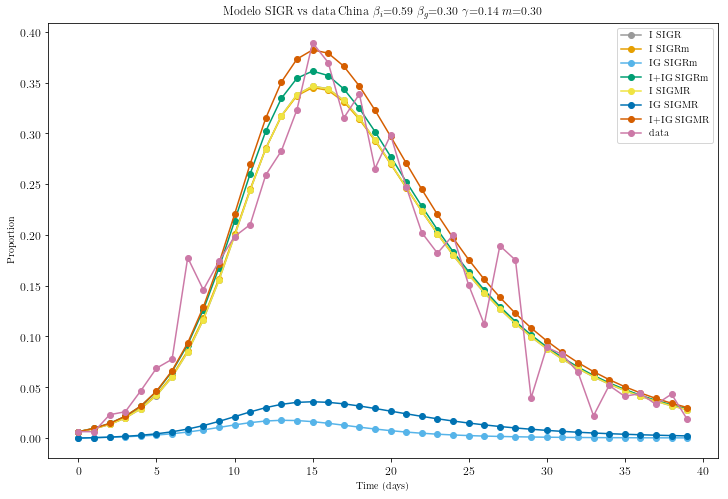

In [154]:
fig6,ax6=plt.subplots(1,1,figsize=(12,8))
ax6.plot(tdf,Isigr,'-o',label='I SIGR')
ax6.plot(tdf,Isigrm,'-o',label='I SIGRm')
ax6.plot(tdf,IGsigrm,'-o',label='IG SIGRm')
ax6.plot(tdf,Isigrm+IGsigrm,'-o',label='I+IG SIGRm')
ax6.plot(tdf,Isigmr,'-o',label='I SIGMR')
ax6.plot(tdf,IGsigmr,'-o',label='IG SIGMR')
ax6.plot(tdf,Isigmr+IGsigmr,'-o',label='I+IG SIGMR')
ax6.plot(tdf,df['I'],'-o',label='data')
ax6.set_title('Modelo SIGR vs data China '+r'$\beta_i$='+r'%0.2f'%biBsigrm+r' $\beta_g$='+r'%0.2f'%bgBsigrm+r' $\gamma$='+r'%0.2f'%gBsigrm+r' $m$='+r'%0.2f'%mBsigrm)
ax6.set_xlabel('Time (days)')
ax6.set_ylabel('Proportion')
ax6.legend()

## Comparing approaches

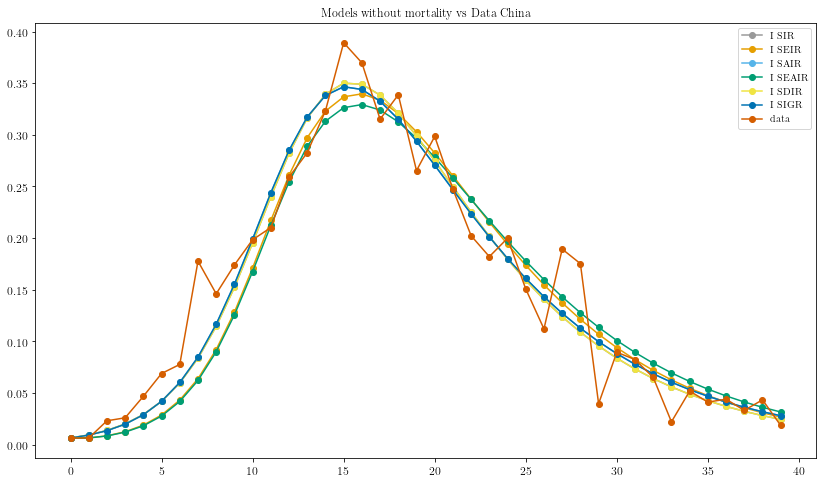

In [155]:
#Without mortality
figAll,axAll=plt.subplots(1,1,figsize=(14,8))
axAll.set_title('Models without mortality vs Data China')
axAll.plot(tdf,I,'-o', label="I SIR")
axAll.plot(tdf,Iseir,'-o', label="I SEIR")
axAll.plot(tdf,Isair,'-o', label="I SAIR")
axAll.plot(tdf,Iseair,'-o', label="I SEAIR")
axAll.plot(tdf,Isdir,'-o', label="I SDIR")
axAll.plot(tdf,Isigr,'-o', label="I SIGR")
axAll.plot(tdf,df['I'],'-o', label="data")
axAll.legend(loc='best')

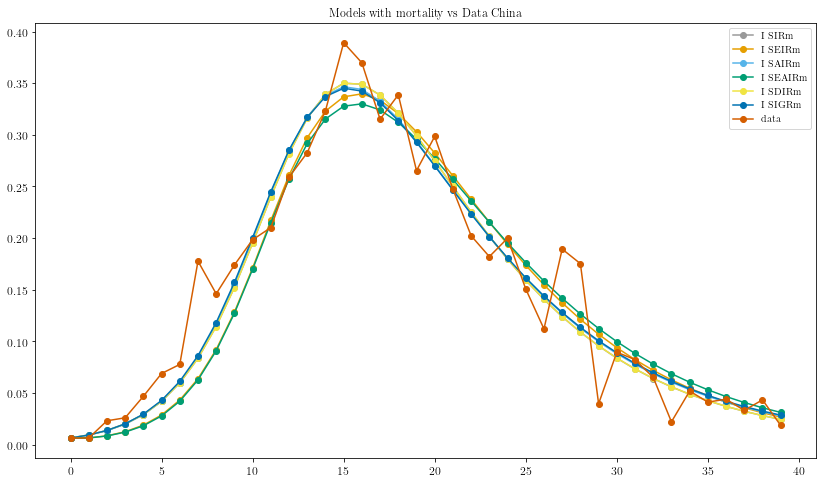

In [156]:
#With mortality
figAllm,axAllm=plt.subplots(1,1,figsize=(14,8))
axAllm.set_title('Models with mortality vs Data China')
axAllm.plot(tdf,Im,'-o', label="I SIRm")
axAllm.plot(tdf,Iseirm,'-o', label="I SEIRm")
axAllm.plot(tdf,Isairm,'-o', label="I SAIRm")
axAllm.plot(tdf,Iseairm,'-o', label="I SEAIRm")
axAllm.plot(tdf,Isdirm,'-o', label="I SDIRm")
axAllm.plot(tdf,Isigrm,'-o', label="I SIGRm")
axAllm.plot(tdf,df['I'],'-o', label="data")
axAllm.legend(loc='best')

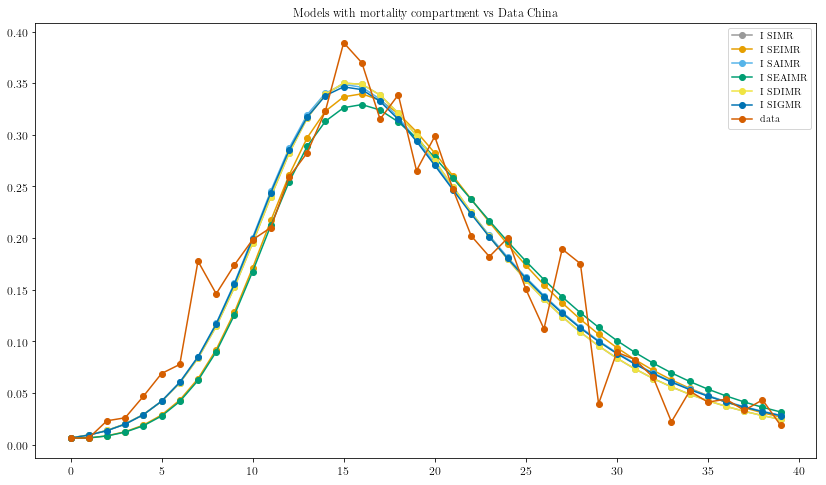

In [157]:
#With mortality compartment
figAllm,axAllm=plt.subplots(1,1,figsize=(14,8))
axAllm.set_title('Models with mortality compartment vs Data China')
axAllm.plot(tdf,Im2,'-o', label="I SIMR")
axAllm.plot(tdf,Iseimr,'-o', label="I SEIMR")
axAllm.plot(tdf,Isaimr,'-o', label="I SAIMR")
axAllm.plot(tdf,Iseaimr,'-o', label="I SEAIMR")
axAllm.plot(tdf,Isdimr,'-o', label="I SDIMR")
axAllm.plot(tdf,Isigmr,'-o', label="I SIGMR")
axAllm.plot(tdf,df['I'],'-o', label="data")
axAllm.legend(loc='best')

## Comparing solutions of models

In [158]:
# Without mortality
t1=np.arange(0,50,1)

sol_sir=odeint(sir,[init_s(),init_i(),init_r()],t1,args=(bBsir,gBsir))
sol_seir=odeint(seir,[init_s(),init_e(),init_i(),init_r()],t1,args=(bBseir,eBseir,gBseir))
sol_sair=odeint(sair,[init_s(),init_a(),init_i(),init_r()],t1,args=(baBsair,biBsair,pBsair,gBsair))
sol_seair=odeint(seair,[init_s(),init_e(),init_a(),init_i(),init_r()],t1,args=(baBseair,biBseair,eBseair,pBseair,gBseair))
sol_sdir=odeint(sdir,[init_s(),init_sd(),init_i(),init_r()],t1,args=(biBsdir,pBsdir,gBsdir))
sol_sigr=odeint(sigr,[init_s(),init_i(),init_id(),init_r()],t1,args=(biBsigr,bgBsigr,pBsigr,gBsigr))


I1sir=sol_sir.T[1]
#1sir_gm=sol_sir_gm.T[1]
I1seir=sol_seir.T[2]
I1sair=sol_sair.T[2]
I1seair=sol_seair.T[3]
I1sdir=sol_sdir.T[2]
I1sigr=sol_sigr.T[1]

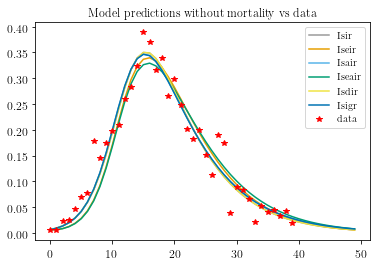

In [159]:
solsi=[I1sir,I1seir,I1sair,I1seair,I1sdir,I1sigr]
sol_labels=['Isir','Iseir','Isair','Iseair','Isdir','Isigr']

for soli,i in zip(solsi,range(len(solsi))):
    plt.plot(soli,label=sol_labels[i])
plt.plot(tdf,df['I'],'*',label='data',color='r')
plt.legend()
plt.title('Model predictions without mortality vs data')
plt.savefig(os.path.join(path,'predictionsWOmortality'+'.pdf'),format='pdf')

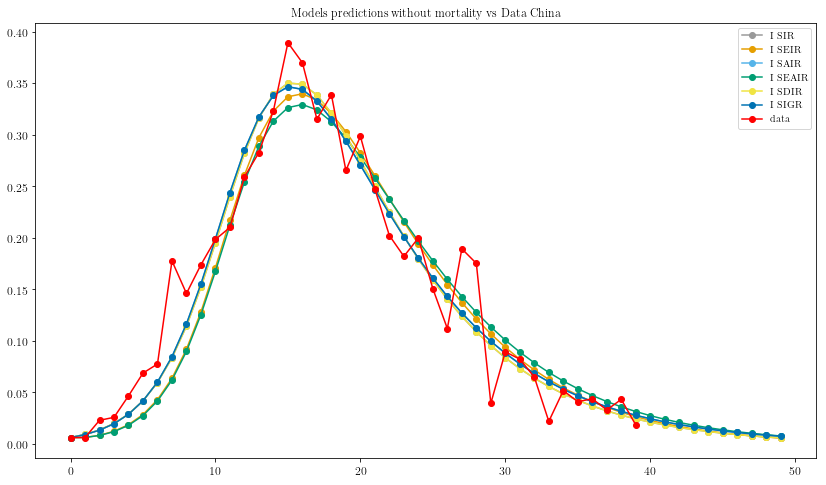

In [160]:
figAllP,axAllP=plt.subplots(1,1,figsize=(14,8))
axAllP.set_title('Models predictions without mortality vs Data China')
axAllP.plot(I1sir,'-o', label="I SIR")
axAllP.plot(I1seir,'-o', label="I SEIR")
axAllP.plot(I1sair,'-o', label="I SAIR")
axAllP.plot(I1seair,'-o', label="I SEAIR")
axAllP.plot(I1sdir,'-o', label="I SDIR")
axAllP.plot(I1sigr,'-o', label="I SIGR")
axAllP.plot(tdf,df['I'],'-o', color='r',label="data")
axAllP.legend(loc='best')

In [161]:
#With mortality
t1=np.arange(0,50,1)

sol_sirm=odeint(sirm,[init_s(),init_i(),init_r()],t1,args=(bBsirm,gBsirm,mBsirm))
sol_seirm=odeint(seirm,[init_s(),init_e(),init_i(),init_r()],t1,args=(bBseirm,eBseirm,gBseirm,mBseirm))
sol_sairm=odeint(sairm,[init_s(),init_a(),init_i(),init_r()],t1,args=(baBsairm,biBsairm,pBsairm,gBsairm,mBsairm))
sol_seairm=odeint(seairm,[init_s(),init_e(),init_a(),init_i(),init_r()],t1,args=(baBseairm,biBseairm,eBseairm,pBseairm,gBseairm,mBseairm))
sol_sdirm=odeint(sdirm,[init_s(),init_sd(),init_i(),init_r()],t1,args=(biBsdirm,pBsdirm,gBsdirm,mBsdirm))
sol_sigrm=odeint(sigrm,[init_s(),init_i(),init_id(),init_r()],t1,args=(biBsigrm,bgBsigrm,pBsigrm,gBsigrm,mBsigrm))


I1sirm=sol_sirm.T[1]
#1sir_gm=sol_sir_gm.T[1]
I1seirm=sol_seirm.T[2]
I1sairm=sol_sairm.T[2]
I1seairm=sol_seairm.T[3]
I1sdirm=sol_sdirm.T[2]
I1sigrm=sol_sigrm.T[1]

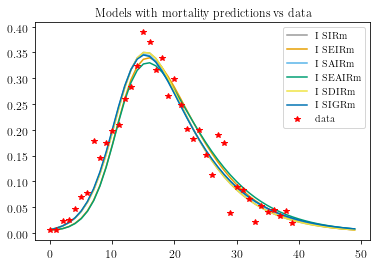

In [162]:
solsim=[I1sirm,I1seirm,I1sairm,I1seairm,I1sdirm,I1sigrm]
solm_labels=['I SIRm','I SEIRm','I SAIRm','I SEAIRm','I SDIRm','I SIGRm']

for solim,i in zip(solsim,range(len(solsi))):
    plt.plot(solim,label=solm_labels[i])
plt.plot(tdf,df['I'],'*',label='data',color='r')
plt.legend()
plt.title('Models with mortality predictions vs data')
plt.savefig(os.path.join(path,'predictionsMortality'+'.pdf'),format='pdf')

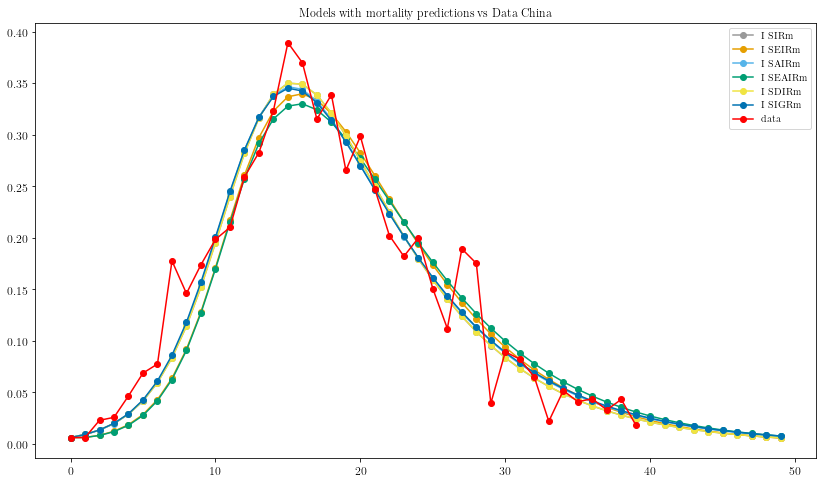

In [163]:
figAllmP,axAllmP=plt.subplots(1,1,figsize=(14,8))
axAllmP.set_title('Models with mortality predictions vs Data China')
axAllmP.plot(I1sirm,'-o', label="I SIRm")
axAllmP.plot(I1seirm,'-o', label="I SEIRm")
axAllmP.plot(I1sairm,'-o', label="I SAIRm")
axAllmP.plot(I1seairm,'-o', label="I SEAIRm")
axAllmP.plot(I1sdirm,'-o', label="I SDIRm")
axAllmP.plot(I1sigrm,'-o', label="I SIGRm")
axAllmP.plot(tdf,df['I'],'-o', color='r',label="data")
axAllmP.legend(loc='best')

In [164]:
#With mortality compartment
t1=np.arange(0,50,1)

sol_simr=odeint(simr,[init_s2(),init_i2(),init_m2(),init_r2()],t1,args=(bBsimr,gBsimr,mBsimr))
sol_seimr=odeint(seimr,[init_s2(),init_e2(),init_i2(),init_m2(),init_r2()],t1,args=(bBseimr,eBseimr,gBseimr,mBseimr))
sol_saimr=odeint(saimr,[init_s2(),init_a2(),init_i2(),init_m2(),init_r2()],t1,args=(baBsaimr,biBsaimr,pBsaimr,gBsaimr,mBsaimr))
sol_seaimr=odeint(seaimr,[init_s2(),init_e2(),init_a2(),init_i2(),init_m2(),init_r2()],t1,args=(baBseaimr,biBseaimr,eBseaimr,pBseaimr,gBseaimr,mBseaimr))
sol_sdimr=odeint(sdimr,[init_s2(),init_sd2(),init_i2(),init_m2(),init_r2()],t1,args=(biBsdimr,pBsdimr,gBsdimr,mBsdimr))
sol_sigmr=odeint(sigmr,[init_s2(),init_i2(),init_id2(),init_m2(),init_r2()],t1,args=(biBsigmr,bgBsigmr,pBsigmr,gBsigmr,mBsigmr))


I1simr=sol_simr.T[1]
I1seimr=sol_seimr.T[2]
I1saimr=sol_saimr.T[2]
I1seaimr=sol_seaimr.T[3]
I1sdimr=sol_sdimr.T[2]
I1sigmr=sol_sigmr.T[1]

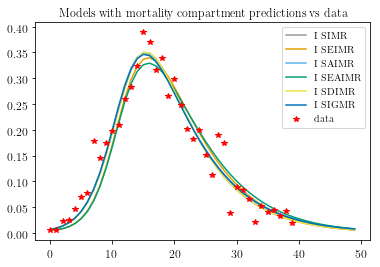

In [165]:
solsim=[I1simr,I1seimr,I1saimr,I1seaimr,I1sdimr,I1sigmr]
solm_labels=['I SIMR','I SEIMR','I SAIMR','I SEAIMR','I SDIMR','I SIGMR']

for solim,i in zip(solsim,range(len(solsi))):
    plt.plot(solim,label=solm_labels[i])
plt.plot(tdf,df['I'],'*',label='data',color='r')
plt.legend()
plt.title('Models with mortality compartment predictions vs data')
plt.savefig(os.path.join(path,'predictionsMortalityComp'+'.pdf'),format='pdf')

### AIC MODEL COMPARISON

In [168]:
RSSv = [] 
RSSv = np.zeros(12)
AICv = []
AICv = np.zeros(12)

In [169]:
infec_sols=[Im,Iseirm,Isairm,Iseairm,Isdirm,Isigrm, Im2,Iseimr,Isaimr,Iseaimr,Isdimr,Isigmr ]
coef=[3,4,5,6,4,5,3,4,5,6,4,5] #number of parámetros to estimate

In [170]:
for i,j in zip(infec_sols,range(len(infec_sols))):
        RSSv[j]=0.5*np.sum((df['I']-i)**2)
        AICv[j]=len(df['I'])*math.log10(RSSv[j]/len(df['I']))+ 2*coef[j]*len(df['I'])/(len(df['I'])-coef[j]-1)

In [171]:
grade = np.argmin(AICv)+1

In [172]:
AICv

array([-127.80834908, -120.46250425, -122.617106  , -113.87726642,
       -125.33205175, -122.75223531, -127.80834546, -120.46250354,
       -122.5762573 , -113.4258779 , -125.33215443, -122.62821313])

In [173]:
def aic_order(aics):
    aics_ordered=sorted(aics)
    
    list_index=dict()
    
    for i in range(len(aics)):
        #list_index['d'+r'%0.f'%i]=aics.index([dist_ordered[i]])
        list_index['d'+r'%0.f'%i]=np.where(aics==aics_ordered[i])
    
    return(aics_ordered,list_index)

In [174]:
(aic_order(AICv))

([-127.80834907561344,
  -127.80834545517955,
  -125.33215442715479,
  -125.33205174646508,
  -122.7522353116204,
  -122.62821312949602,
  -122.61710600339443,
  -122.5762573045164,
  -120.46250424961235,
  -120.46250353844303,
  -113.87726642037997,
  -113.42587789798459],
 {'d0': (array([0], dtype=int32),),
  'd1': (array([6], dtype=int32),),
  'd2': (array([10], dtype=int32),),
  'd3': (array([4], dtype=int32),),
  'd4': (array([5], dtype=int32),),
  'd5': (array([11], dtype=int32),),
  'd6': (array([2], dtype=int32),),
  'd7': (array([8], dtype=int32),),
  'd8': (array([1], dtype=int32),),
  'd9': (array([7], dtype=int32),),
  'd10': (array([3], dtype=int32),),
  'd11': (array([9], dtype=int32),)})

In [178]:
figs=[fig1,fig2,fig3,fig4,fig5,fig6,figAllP,figAllmP]
labels=['fig1','fig2','fig3','fig4','fig5','fig6','figAllP','figAllmP']

In [179]:
for fig,l in zip(figs,range(len(figs))):
    save_fig(fig,labels[l])
    